In [8]:
"""
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pandas as pd
from statistics import mean
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
import plotly.graph_objects as go
""";

In [6]:
img_names = ['R1B1ROI1', 'R1B1ROI2', 'R1C1ROI1', 'R1C1ROI2', 'R1D1ROI1', 'R1D1ROI2']

['R1B1ROI1', 'R1B1ROI2', 'R1C1ROI1', 'R1C1ROI2', 'R1D1ROI1', 'R1D1ROI2']

In [14]:
# Load all masks from folder
masks = {}
maskdir = '../02_Segmentation/FinalNucleiCytoSeg/'
for i in img_names:
    filename = i + "_NucleiCytoSegmentationV2.tif"
    maskpath = os.path.join(maskdir, filename)
    mask = io.imread(maskpath)
    masks[i] = mask

In [284]:
# Load in intensity data frames, save dfs, centroids, cell types
intensitydir = "../00_Data/IntensitiesCelltypes/"

intensitydfs = {}
centroids = {}
celltypes = {}
areas = {}

for i in img_names:
    filename = i + "_intensitiesdf.csv"
    filepath = os.path.join(intensitydir, filename)
    df = pd.read_csv(filepath)
    
    X_coords = df["X_coord"]
    Y_coords = df["Y_coord"]
    centroidsdf = df[["X_coord", "Y_coord"]]
    centroids[i] = centroidsdf

    celltype = df["InferredCellType"]
    celltypes[i] = celltype
    
    area = df["area"]
    areas[i] = area
    
    df = df.iloc[:, 1:-4] # drop first column, is just the cell index, and area, inf.c.t. and centroids
    intensitydfs[i] = df
    

In [273]:
markers = list(intensitydfs["R1B1ROI1"].columns)
print("You are working with the biomarkers {}.".format(markers))
print()

# Reminder of all possible cell types:
print("All cell types:", np.unique(celltypes["R1B1ROI1"]))

You are working with the biomarkers ['actin', 'cd3', 'cd4', 'cd45', 'cd45ro', 'collageni', 'cytokeratin', 'fibulin2', 'lyve1', 'podoplanin', 'cd38', 'cd138'].

All cell types: ['B-cells Plasma' 'Epithelial cells' 'Extracellular matrix'
 'Lymphatic vessel' 'Mixed' 'Myocytes' 'Other' 'T-cells CD4+ (helper)'
 'T-cells Memory' 'T-cells Mixed' 'T-cells Naive']


In [53]:
intensitydfs["R1B1ROI1"]

,actin,cd3,cd4,cd45,cd45ro,collageni,cytokeratin,fibulin2,lyve1,podoplanin,cd38,cd138
0,2267,7279,680,651,4858,1265,5457,6178,1917,3903,618,9684
1,2550,7433,3287,517,15970,2415,5312,6493,1920,538,816,9158
2,1913,8277,5341,1362,9727,1145,6841,4474,2163,5597,1953,9848
3,2525,7557,1108,298,5619,1564,7415,6858,2010,15072,717,10962
4,4271,7910,915,338,4610,33,7120,3326,1993,3715,548,11231
...,...,...,...,...,...,...,...,...,...,...,...,...
11729,2365,6330,1051,346,4296,97,4328,1991,1754,2264,629,10322
11730,2159,5598,757,261,7918,290,5407,3446,1401,1199,532,9288
11731,1619,5582,673,552,9131,564,6197,1459,1414,2871,595,9174
11732,2022,6136,838,3116,3484,594,5803,1454,1720,7635,619,9046


In [186]:
# Distance Matrix function

# Function for computing distances between two cell types WITH CENTROIDS
def celltypes_distance_matrix_func(ct1, ct2, celltypes_array, centroids, pool_tcells=False, include_mixed=True, include_other=True):

    cellt = celltypes_array
    centr = centroids
    
    if include_mixed == False:
        indices_to_keep =(cellt != "Mixed")
        centr = centr[indices_to_keep]
        cellt = cellt[indices_to_keep]
        
    if include_other == False:
        indices_to_keep =(cellt != "Other")
        centr = centr[indices_to_keep]
        cellt = cellt[indices_to_keep]
        
    if pool_tcells == True: # Make all T-cell variants into the same
        cellt = np.where(cellt == "T-cells Mixed", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Naive", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells CD4+ (helper)", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Memory", "T-cells", cellt)
        #print(cellt[:10])
        
    if len(ct2) == 1:
        # Getting cell indexes from cell types from celltypes_array
        ct1cells = np.where(cellt == ct1)[0]
        ct2cells = np.where(cellt == ct2[0])[0]

        # Making centroids arrays for the selected cells
        ct1coords = centr[ct1cells]
        ct2coords = centr[ct2cells]

        # Calculate distance matrix
        dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
        print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct2[0], dist_mat.shape[0], dist_mat.shape[1]))
    
        return(dist_mat)

    else:
        multiple_dist_mat = {}
        
        for ct in ct2:
            # Getting cell indexes from cell types from celltypes_array
            ct1cells = np.where(cellt == ct1)[0]
            ct2cells = np.where(cellt == ct)[0]

            # Making centroids arrays for the selected cells
            ct1coords = centr[ct1cells]
            ct2coords = centr[ct2cells]

            # Calculate distance matrix
            dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
            print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct, dist_mat.shape[0], dist_mat.shape[1]))
            #multiple_dist_mat[ct] = dist_mat.flatten()
            multiple_dist_mat[ct] = dist_mat
        
        return(multiple_dist_mat)





In [233]:
# Make distance matrices for pooled t cells
dist_mat_pooled_t = {}
ct1 = "T-cells"
ct2 = ["Epithelial cells", "Extracellular matrix", "Lymphatic vessel", "Myocytes"]
pool_tcells = True

for i in img_names:
    celltypes_array = celltypes[i].to_numpy()
    centroids = centroids[i].to_numpy()
    dist_mat = celltypes_distance_matrix_func(ct1, 
                                              ct2, 
                                              celltypes_array, 
                                              centroids, 
                                              pool_tcells=pool_tcells)
    dist_mat_pooled_t[i] = dist_mat
    print()



In the distance matrix for the cell types T-cells and Epithelial cells, there are 842 rows and 1974 columns.
In the distance matrix for the cell types T-cells and Extracellular matrix, there are 842 rows and 1319 columns.
In the distance matrix for the cell types T-cells and Lymphatic vessel, there are 842 rows and 209 columns.
In the distance matrix for the cell types T-cells and Myocytes, there are 842 rows and 467 columns.

In the distance matrix for the cell types T-cells and Epithelial cells, there are 860 rows and 235 columns.
In the distance matrix for the cell types T-cells and Extracellular matrix, there are 860 rows and 127 columns.
In the distance matrix for the cell types T-cells and Lymphatic vessel, there are 860 rows and 193 columns.
In the distance matrix for the cell types T-cells and Myocytes, there are 860 rows and 122 columns.

In the distance matrix for the cell types T-cells and Epithelial cells, there are 714 rows and 1255 columns.
In the distance matrix for the 

In [264]:
def plot_violin(data_dict, name, ct1, ct2, show=False):
    
    if len(ct2) == 1:
        print("short")
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the violin plot
        parts = ax.violinplot(data_dict.flatten(), showmeans=True, showmedians=False)

        # Customize the plot (optional)
        ax.set_title("Violin plot of {} distances to {} for {}".format(ct1, ct2[0], name))
        ax.set_xlabel(ct2[0])
        ax.set_ylabel("Distances")

        if show:
            print(show)
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
        
    else:
        keys = list(data_dict.keys())
        data = [data_dict[key].flatten() for key in keys]

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the violin plot
        parts = ax.violinplot(data, showmeans=True, showmedians=False)

        # Set the x-ticks and x-tick labels
        ax.set_xticks(np.arange(1, len(keys) + 1))
        ax.set_xticklabels(keys)

        # Compute and plot the means manually (optional customization)
        means = [np.mean(d) for d in data]
        ax.scatter(np.arange(1, len(keys) + 1), means, color='red', marker='o', s=50, zorder=3, label='Mean')

        # Annotate the means with their values
        for j, mean in enumerate(means):
            ax.text(j + 1, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=10, color='red')


        # Customize the plot (optional)
        title = "Violin plot of T-cell distances to structural markers for " + name
        ax.set_title(title)
        ax.set_xlabel('Inferred Cell Types')
        ax.set_ylabel('Distances')

        if show:
            print(show)
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
    
    return fig
    

In [270]:
# Create separate violin plots for all images
figures_pooled_t = {}
for i in img_names:
    fig = plot_violin(dist_mat_pooled_t[i], i, ct1, ct2, show=False)
    figures_pooled_t[i] = fig


In [255]:
# Make pooled dist mat for all images
dist_mat_pooled_t_ALLIMG = {}

for ct in ct2: # Loop through cell types
    for i in dist_mat_pooled_t: # Loop through images
        img = dist_mat_pooled_t[i]
        flat_array = img[ct].flatten()
        if ct in dist_mat_pooled_t_ALLIMG:
            dist_mat_pooled_t_ALLIMG[ct] = np.concatenate((dist_mat_pooled_t_ALLIMG[ct], flat_array))
        else:
            dist_mat_pooled_t_ALLIMG[ct] = flat_array



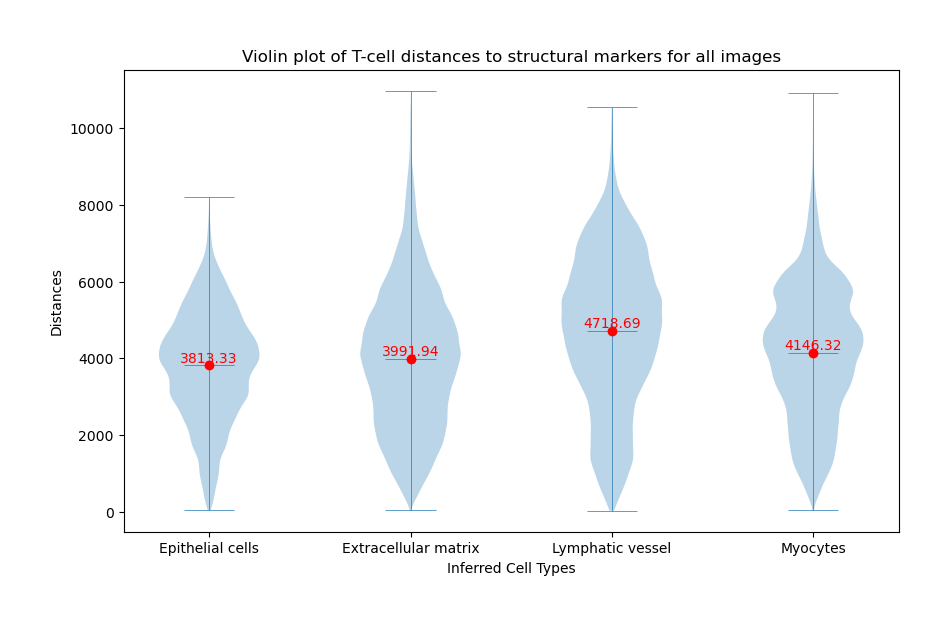

In [269]:
all_img_fig = plot_violin(dist_mat_pooled_t[i], "all images", ct1, ct2, show=False)
plt.figure(all_img_fig)
plt.show()

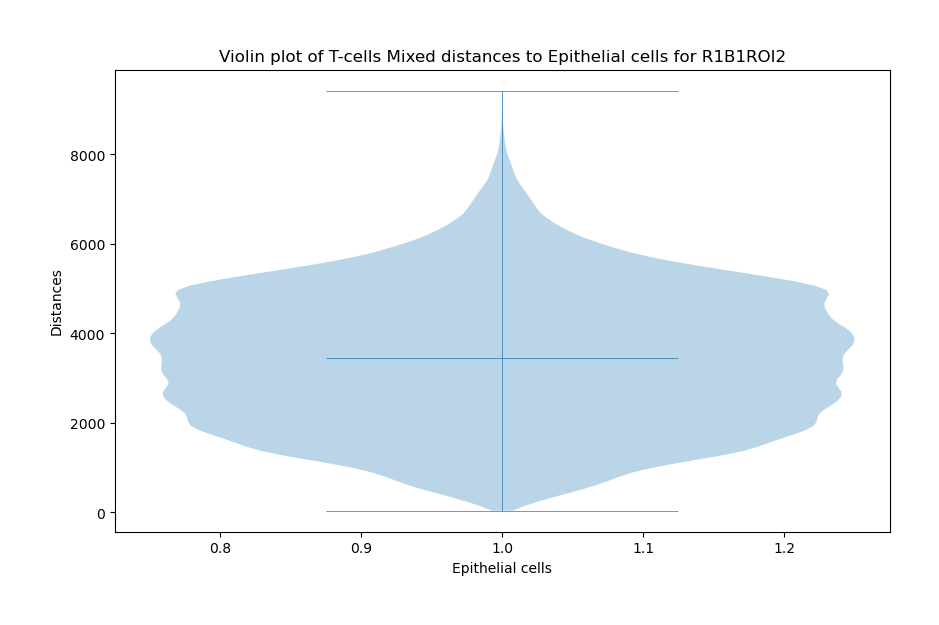

In [223]:
# Save figures:
#for key, fig in figures_dict.items():
    #fig.savefig(f'violin_plot_{key}.png')
    
# Plot just one:
plt.figure(figures_pooled_t["R1B1ROI2"])
plt.show()

## Sankey diagram

In [355]:
# Filtering
# For this instance, I want to remove "Other" and "Mixed" from this
celltypes_array = celltypes["R1B1ROI1"]
centroids_array = centroids["R1B1ROI1"]

indices_to_keep = (celltypes_array != "Other") & (celltypes_array != "Mixed") & (celltypes_array != "B-cells Plasma")

centroids_array = centroids_array[indices_to_keep]
celltypes_array = celltypes_array[indices_to_keep]

In [373]:
# Function for creating From-To-Table (table showing closest cell type for every T-cell)

# How big should the radius of cells be? If all cells, put None
radius = 3

cellTypes = np.unique(celltypes_array)

## Add numbers of cells to data frame
# Create t cells df to loop through
t_indices = (celltypes_array == "T-cells Memory") | (celltypes_array == "T-cells Mixed") | (celltypes_array == "T-cells Naive") | (celltypes_array == "T-cells CD4+ (helper)")
t_centroids = centroids_array[t_indices]
t_celltypes = celltypes_array[t_indices]


# Create all other cell types dfs
nott_centroids = centroids_array[~t_indices]
nott_celltypes = celltypes_array[~t_indices]

def create_fromtotable(fromcentroids, tocentroids, radius, cellTypes, fromcelltypes, tocelltypes):
    
    # Initialise data frame with combinations of cell types as columns
    combi = []
    for i in cellTypes:
        for j in cellTypes:
            if i != j and i.startswith("T-cells"): # Only want to include T-cells in "From"
                combi.append([i, j, 0])
    fromto_df = pd.DataFrame(combi, columns=["From", "To", "Amount"])
    

    
    # Convert structured pandas df to numpy arrays of tuples
    fromcentroids = fromcentroids.to_records(index=False)  # BY actual index
    fromcentroids = np.array([tuple(row) for row in fromcentroids])
    tocentroids = tocentroids.to_records(index=False)  # BY actual index
    tocentroids = np.array([tuple(row) for row in tocentroids])
    
    # Convert pandas series to numpy arrays
    fromcelltypes = fromcelltypes.to_numpy()
    tocelltypes = tocelltypes.to_numpy()
    

    # Loop through each cell one by one and calculate distances
    for idx in range(len(fromcentroids)):
        
        # Calculate distance matrix from this cell idx to all other cells
        cell = fromcentroids[idx] # Cell coordinates of current cell
        distances = np.linalg.norm(tocentroids - cell, axis=1) # Np array with all distances for "cell" to all "to" celltypes
        
        # Find cells closest, amount of closest cells specified by radius
        if radius != None:
            distance_idxs = distances.argsort()[:radius] # indexes of closest ones within radius
            distances = distances[distance_idxs] # centroids of closest ones within radius
            selection_celltypes = tocelltypes[distance_idxs] # the cell types of the cells that were closest    
       
        # Find lowest average distance celltype for this specific cell
        averages_distances = [] # Initialise empty dict for averages
        for ct in cellTypes:
            ctdistances = distances[(selection_celltypes == ct)] # Will be empty for all cell types that were not within radius
            
            # Append distance value (or -1 if no cell of this ct near) to averages_distances at the index of ct
            if len(ctdistances) != 0:
                averages_distances.append(np.mean(ctdistances)) 
            else:
                averages_distances.append(-1)

        
        # Add indication about nearest (lowest dist) celltype for this cell to fromto_df
        # Identify the one closest cell type (lowest average distance)
        closest = averages_distances.index(min([i for i in averages_distances if i >= 0])) 
        fromtype = fromcelltypes[idx]
        totype = cellTypes[closest]
        # Write to data frame
        fromto_df.loc[(fromto_df["From"] == fromtype) & (fromto_df["To"] == totype), "Amount"] += 1

    return(fromto_df)
        
fromto_df = create_fromtotable(t_centroids, nott_centroids, radius, cellTypes, t_celltypes, nott_celltypes)
   



In [405]:
to_cts = ["Epithelial cells", "Lymphatic vessel", "Myocytes"]
cellTypes = np.unique(celltypes_array).tolist()
    
### Filtering

# In to_cts, we have the cts that we want to keep, so now we need a list of what we want to remove
TO_remove = [c for c in cellTypes if c not in to_cts]
# Loop through cell types that should NOT be in the "to" section, aka NOT on the right side of Sankey
# Could either be cts that should be on the left section, or ones that we remove completely (e.g. "Other")
for i in TO_remove:
    TO_indices_to_keep = (celltypes_array != i)
    print(i, ":", sum(TO_indices_to_keep))

print(sum(TO_indices_to_keep))




B-cells Plasma : 11733
Extracellular matrix : 10415
Mixed : 7221
Other : 9325
T-cells CD4+ (helper) : 11692
T-cells Memory : 11728
T-cells Mixed : 10970
T-cells Naive : 11704
11704


In [410]:
to_cts = ["Epithelial cells", "Lymphatic vessel", "Myocytes"]
cellTypes = np.unique(celltypes_array).tolist()

TO_indices_to_keep = np.isin(celltypes_array, to_cts)
print(sum(TO_indices_to_keep))
print(np.unique(celltypes_array[TO_indices_to_keepices_to_keep]))

2650
['Epithelial cells' 'Lymphatic vessel' 'Myocytes']


In [420]:


def create_fromtotable(celltypes_array, centroids_array, from_cts, to_cts, radius, cellTypes):
    
    cellTypes = np.unique(celltypes_array).tolist()
    
    ### Filtering
    
    # Create from and to dfs
    # "FROM" = on the left side of sankey diagram e.g. all T-cells
    # "TO" = on the right side of sankey diagram, e.g. all structural cell types
    TO_indices_to_keep = np.isin(celltypes_array, to_cts)
    FROM_indices_to_keep = np.isin(celltypes_array, from_cts)

    from_centroids = centroids_array[FROM_indices_to_keep]
    from_celltypes = celltypes_array[FROM_indices_to_keep]

    # Create all other cell types dfs
    to_centroids = centroids_array[TO_indices_to_keep]
    to_celltypes = celltypes_array[TO_indices_to_keep]
   

    ### Conversion (for easier computation)
    
    # Convert structured pandas df to numpy arrays of tuples
    from_centroids = from_centroids.to_records(index=False)  # BY actual index
    from_centroids = np.array([tuple(row) for row in from_centroids])
    to_centroids = to_centroids.to_records(index=False)  # BY actual index
    to_centroids = np.array([tuple(row) for row in to_centroids])
    
    # Convert pandas series to numpy arrays
    from_celltypes = from_celltypes.to_numpy()
    to_celltypes = to_celltypes.to_numpy()
    

    
    ### Initialising data frame
    
    # Initialise data frame with combinations of cell types as columns
    combi = []
    for i in from_cts:
        for j in to_cts:
            if i != j: # Only want to include T-cells in "From"
                combi.append([i, j, 0])
    fromto_df = pd.DataFrame(combi, columns=["From", "To", "Amount"])
    

    
    ### Distances computation

    # Loop through each cell one by one and calculate distances
    for idx in range(len(from_centroids)):
        
        # Calculate distance matrix from this cell idx to all other cells
        cell = from_centroids[idx] # Cell coordinates of current cell
        distances = np.linalg.norm(to_centroids - cell, axis=1) # Np array with all distances for "cell" to all "to" celltypes
        
        # Find cells closest, amount of closest cells specified by radius
        if radius != None:
            distance_idxs = distances.argsort()[:radius] # indexes of closest ones within radius
            distances = distances[distance_idxs] # centroids of closest ones within radius
            selection_celltypes = to_celltypes[distance_idxs] # the cell types of the cells that were closest    
       
        # Find lowest average distance celltype for this specific cell
        averages_distances = [] # Initialise empty dict for averages
        for ct in cellTypes:
            ctdistances = distances[(selection_celltypes == ct)] # Will be empty for all cell types that were not within radius
            
            # Append distance value (or -1 if no cell of this ct near) to averages_distances at the index of ct
            if len(ctdistances) != 0:
                averages_distances.append(np.mean(ctdistances)) 
            else:
                averages_distances.append(-1)

        
        # Add indication about nearest (lowest dist) celltype for this cell to fromto_df
        # Identify the one closest cell type (lowest average distance)
        closest = averages_distances.index(min([i for i in averages_distances if i >= 0])) 
        fromtype = from_celltypes[idx]
        totype = cellTypes[closest]
        # Write to data frame
        fromto_df.loc[(fromto_df["From"] == fromtype) & (fromto_df["To"] == totype), "Amount"] += 1

    return(fromto_df)



In [445]:
###### Create from-to-tables for every image ######
from_to_df_dict = {}

# Define radius
# How big should the radius of cells be? If all cells, put None
radius = 3

# Define which cell types you want on the left (from) and on the right (to) of the sankey diagram
from_cts = ["T-cells Memory", "T-cells Mixed", "T-cells Naive",  "T-cells CD4+ (helper)"]
to_cts = ["Extracellular matrix", "Lymphatic vessel", "Epithelial cells", "Myocytes"]
   

for i in img_names:
    cellTypes = np.unique(celltypes[i])
    celltypes_array = celltypes[i]
    centroids_array = centroids[i]
    
    fromto_df = create_fromtotable(celltypes_array, centroids_array, from_cts, to_cts, radius, cellTypes)
    from_to_df_dict[i] = fromto_df
    print("From-To-DF for the image {} created and saved to dict.".format(i))


fromto_df = create_fromtotable(celltypes[i], centroids[i], from_cts, to_cts, radius, cellTypes)


From-To-DF for the image R1B1ROI1 created and saved to dict.
From-To-DF for the image R1B1ROI2 created and saved to dict.
From-To-DF for the image R1C1ROI1 created and saved to dict.
From-To-DF for the image R1C1ROI2 created and saved to dict.
From-To-DF for the image R1D1ROI1 created and saved to dict.
From-To-DF for the image R1D1ROI2 created and saved to dict.


In [458]:
fromto_df = create_fromtotable(celltypes[i], centroids[i], from_cts, to_cts, radius, cellTypes)


In [468]:

def create_sankey(fromto_df, from_cts, to_cts, name, radius):
    df = fromto_df.copy() # We don't want to change our original data frames
    
    # For the sankey plot, we need indices representing cell types rather than strings
    # Create a list of unique nodes (= all cell types we have in our selection)
    nodes = from_cts + to_cts
    # Create indices for them in a dictionary
    node_indices = {node: i for i, node in enumerate(nodes)}

    # Map 'From' and 'To' to their node indices and temporarily add to df
    df['Source'] = df['From'].map(node_indices)
    df['Target'] = df['To'].map(node_indices)

    # Define the Sankey diagram
    sankey_fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[node for node in nodes]
        ),
        link=dict(
            source=df['Source'],
            target=df['Target'],
            value=df['Amount']
        )
    ))


    # Update layout and plot the figure
    sankey_fig.update_layout(title_text="Sankey Diagram of {} closest neighbouring cells for {}".format(radius, name), 
                             font_size=10)
    sankey_fig.show()
    
    return(sankey_fig)
    
    
sankey_fig = create_sankey(fromto_df, from_cts, to_cts, "R1B1ROI1", radius)

#### Create Sankey Plots
Create sankey plots for all images separately and save them to a dictionary for easy acces.

In [471]:

sankey_plots = {}
for i in img_names:
    create_sankey(from_to_df_dict[i], from_cts, to_cts, i, radius)
    
    
    

#### Pool all images

In [480]:
# Initialise combined data frame
combined_from_to_df = None

# Loop through dfs to add "amount" values together
for df in from_to_df_dict.values():
    if combined_from_to_df is None:
        combined_from_to_df = df.copy()
    else:
        combined_from_to_df["Amount"] += df["Amount"]

combined_from_to_df
    
    

,From,To,Amount
0,T-cells Memory,Extracellular matrix,8
1,T-cells Memory,Lymphatic vessel,9
2,T-cells Memory,Epithelial cells,11
3,T-cells Memory,Myocytes,12
4,T-cells Mixed,Extracellular matrix,1291
5,T-cells Mixed,Lymphatic vessel,1063
6,T-cells Mixed,Epithelial cells,1481
7,T-cells Mixed,Myocytes,739
8,T-cells Naive,Extracellular matrix,94
9,T-cells Naive,Lymphatic vessel,34


#### Create Sankey plot for combined df

In [481]:
combined_sankey_fig = create_sankey(combined_from_to_df, from_cts, to_cts, "all images", radius)